### **Example 1:**
We will use K-means to perform color segmentation on an image.

<br>

[Idoia Ochoa](https://portalcientifico.unav.edu/investigadores/329427/detalle) (Tecnun, University of Navarra)

<br>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iochoa/JII-GradoIA/blob/main/notebooks/JII_1_Kmeans_ColorSegmentation_easier_2024.ipynb)


## Common imports and loading image

We will first import some common Python libraries

In [60]:
# For images and importing
from PIL import Image
import requests
from io import BytesIO

# For plotting
import matplotlib.pyplot as plt

# For arrays
import numpy as np

In [62]:
# Mount Google Drive so that you can access the picture
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will now read the image to which we will apply color segmentation.

At the end of the notebook you have code with an example on how to load a different image from the internet, as well as loading one of your pics stored in Google Drive. Just be mindful with the size of the image...

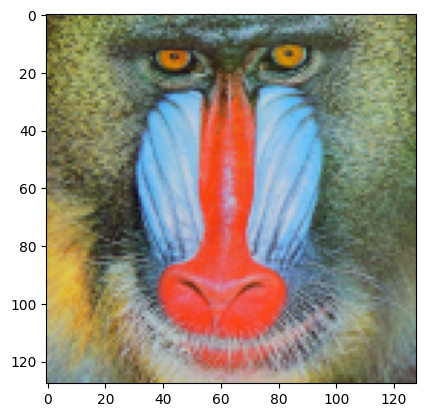

In [63]:
# Load the image
path_img_small = 'https://raw.githubusercontent.com/iochoa/ml-datasets/main/mandrill-small.tiff'

response = requests.get(path_img_small)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

Let's check teh size of the Mandrill image

In [82]:
# Let's check its size
rgb_pixels = np.array(img)
rgb_pixels.shape

(1100, 1600, 3)

Does the shape make sense?

The image is composed of 128 x 128 pixels, with each pixel having 3 channels (R, G, B)

In [83]:
width = rgb_pixels.shape[0]
height = rgb_pixels.shape[1]
channels = rgb_pixels.shape[2]
print('Width is: ', width)
print('Height is: ', height)
print('Number of channels is: ', channels)

Width is:  1100
Height is:  1600
Number of channels is:  3


We will now reshape the image to a 2D-tensor (matrix) of pixels, with dimension (128*128) x 3, i.e., each component of the tensor represents a pixel, composed of 3 channels (R, G, B).

In [84]:
# We use the reshape function
img_vector = np.array(img)
img_vector = img_vector.reshape((width*height, channels))
img_vector.shape

(1760000, 3)

## K-Means clustering

We will now apply K-Means to cluster the pixels by similarity, i.e., we want to group pixels that are similar to each other (based on their R, G, B values) together.

For example, we would like all red(ish) pixels to form a cluster, all blue(ish) pixels to form another cluster, and so on. The clustering algorithm K-means will do this automatically.

In [85]:
# Apply Kmeans with K=16 (this will generate 16 clusters/groups)
from sklearn.cluster import KMeans
k = 16
kmeans = KMeans(n_clusters=k)

# Cluster assignmet for each pixel is stored in vector 'y_pred'
y_pred = kmeans.fit_predict(img_vector)

In [86]:
# y_pred contains the cluster assignment to each pixel (it should range from 0 to 15)
y_pred

array([ 9,  9,  9, ...,  9,  1, 13], dtype=int32)

In [69]:
# We can check how many pixels are assigned to each cluster
np.unique(y_pred, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32),
 array([1131,  989, 1506,  748, 1097,  443, 1156, 1214,  282, 1631,  490,
        1503,  965, 1163, 1193,  873]))

We can generate a bar plot with the number of pixels in each cluster

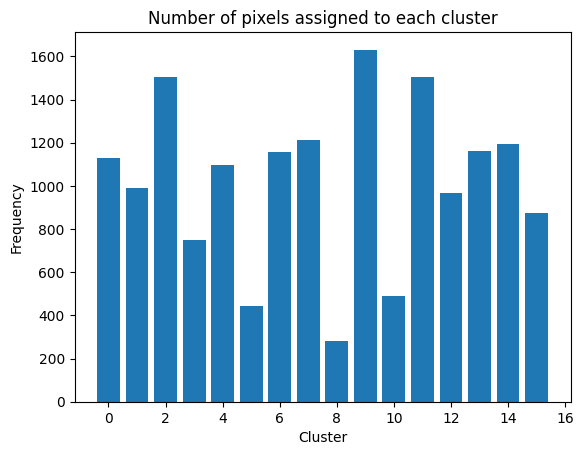

In [70]:
from collections import Counter

# Count the frequency of each element
count = Counter(y_pred)

# Separate the keys (the elements in the vector) and the values (their counts)
elements = list(count.keys())
frequencies = list(count.values())

# Create the bar plot
plt.bar(elements, frequencies)
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Number of pixels assigned to each cluster')
plt.show()

We can now check how the representatives (centroids) of each of these clusters look like.

A cluster representative is computed as the average of all pixels assigned to that cluster, so it can be viewed as the "average pixel" (it should have 3 values for the R, G, B channles).

Hence, we would expect one of them to be red(ish), another one blue(ish), and so on.

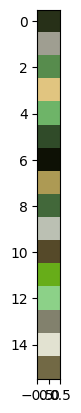

In [87]:
# Plot the centroids to understand better how the clusters look like
tmp = kmeans.cluster_centers_.reshape(16,1,3)
plt.imshow(np.uint8(tmp))

We can also check their R, G, B values explicitly

In [72]:
kmeans.cluster_centers_

array([[157.77541998, 192.68965517, 221.51282051],
       [ 57.9322548 ,  56.40748231,  44.77451972],
       [109.438     , 111.74866667,  76.61533333],
       [220.7459893 , 103.19385027, 100.38368984],
       [162.70394134, 162.18056829, 116.3583868 ],
       [ 96.4954955 , 138.5518018 , 176.48198198],
       [ 89.49437229, 109.04761905, 108.16536797],
       [238.17215815,  77.47281713,  47.68204283],
       [172.4929078 , 106.37943262,  43.43617021],
       [ 81.09932557,  87.47578173,  68.55426119],
       [203.92040816, 168.68571429,  74.71020408],
       [117.03654485, 131.8717608 , 117.6345515 ],
       [179.24559585, 170.24248705, 165.64145078],
       [138.88346187, 154.7403599 , 145.38217652],
       [141.43786489, 138.58215179,  85.86905755],
       [116.78235968, 182.54066438, 227.08705613]])

We can also plots pixels belonging to specific clusters (groups). We would expect pixels of a cluster to loook similar to the corresponding centroid (representative).

In other words, if the representative of a cluster is red(ish), the pixels of that cluster should also look red.

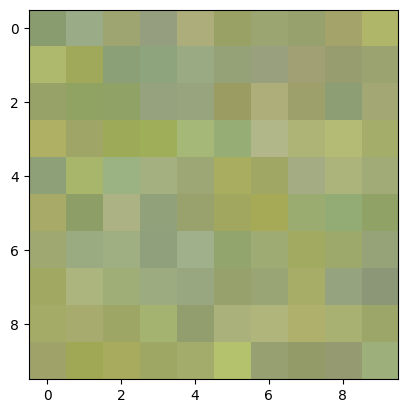

In [73]:
# Select the cluster for which you want to plot pixels assigned to it
cluster = 4

# Select the first 100 pixels
pixels_in_cluster = img_vector[y_pred == cluster][0:100]

# Reshape them to 10x10 for visualization purposes
tmp1 = pixels_in_cluster.reshape(10, 10, 3)

# Plot them
plt.imshow(np.uint8(tmp1))

## Color segmentation (compression)

Next we will substitute all pixels belonging to a cluster, by the representative of that cluster.

After this transformation, the pixels of the newly generated image can take only 16 colors, those of the centroids (see above).

In [89]:
# Subsitute each pixel by the representative of the cluster they belong to
new_image_vector = kmeans.cluster_centers_[y_pred]
new_image_vector.shape

(1760000, 3)

Let's take a closer look at the first pixel, to make sure the new value correspond indeed to the corresponding centroid

In [75]:
# Let's check the pixel value (R,G,B) of the first pixel
print('New pixel: ', new_image_vector[0])

# Cluster assignment of the first pixel
print('Cluster assignment: ', y_pred[0])

# Centroid of that cluster
print('Centroid of cluster ', y_pred[0], ' is ', kmeans.cluster_centers_[y_pred[0]])

New pixel:  [109.438      111.74866667  76.61533333]
Cluster assignment:  2
Centroid of cluster  2  is  [109.438      111.74866667  76.61533333]


We will now plot the newly generated image that has only 16 unique pixels in it

Text(0.5, 1.0, 'New image')

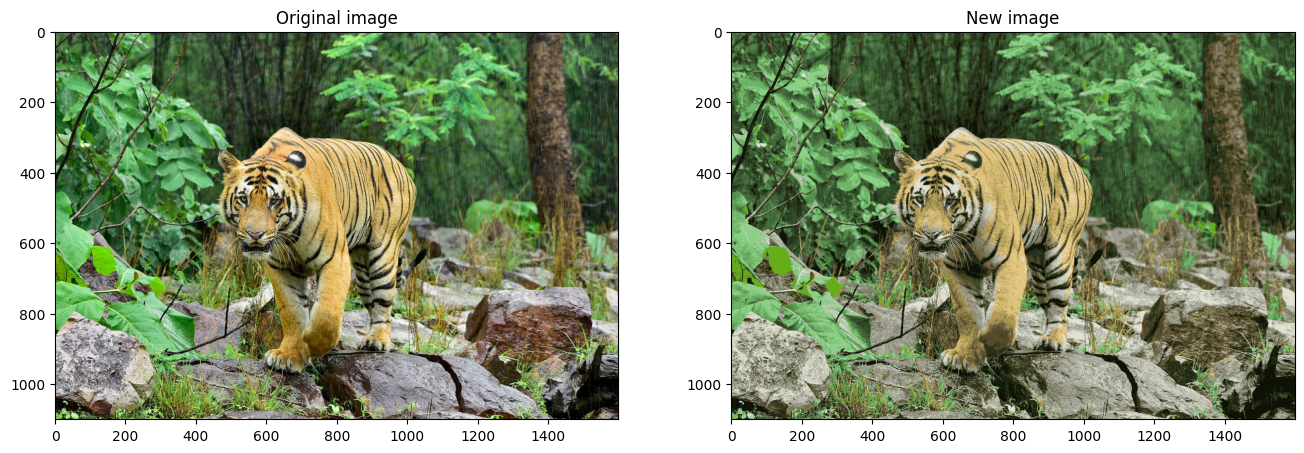

In [90]:
# Reshape back to (128,128,3) to plot it
new_image = new_image_vector.reshape(width,height,channels)
_, axes = plt.subplots(1, 2, figsize=(16, 8))

#Let's plot the original image for comparison
axes[0].imshow(np.uint8(img))

# Plot new image
axes[1].imshow(np.uint8(new_image))

axes[0].set_title('Original image')
axes[1].set_title('New image')

In [77]:
#NO EJECUTAR ESTA CELDA SALVO INDICACION CONTRARIA!!!
file_name = 'mandrill_new'
PIL.Image.fromarray(np.uint8(new_image)).save('/content/drive/MyDrive/fotos/' + file_name + '.jpg')

'/content/drive/MyDrive/fotos/mandrill_new.jpg'

In [58]:
import os
os.getcwd()

'/content'

Let's see how the reconstruction changes for different values of K (number of clusters). Recall that K corresponds to the number of unique pixels in the reconstructed (newly generated) image.

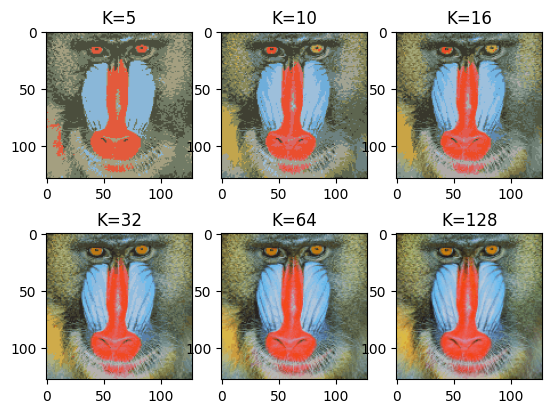

In [23]:
# values of K to test
knumber = [5, 10, 16, 32, 64, 128]

# Apply k-means iteratively for each k
f, axarr = plt.subplots(2,3)
row = 0
col = 0
for k in knumber:
  kmeans = KMeans(n_clusters=k)
  y_pred = kmeans.fit_predict(img_vector)
  new_image_vector = kmeans.cluster_centers_[y_pred]
  new_image = new_image_vector.reshape(128,128,3)
  axarr[row,col].imshow(np.uint8(new_image))
  axarr[row,col].set_title(f"K=%d" % k)
  col += 1
  if col == 3:
    row = 1
    col = 0

## Using other images

Using a different image from the internet

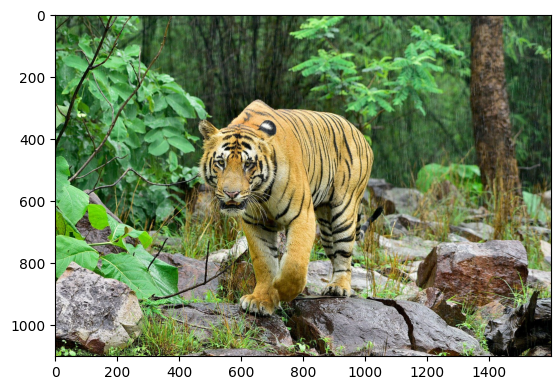

In [80]:
# Just modify the path to point to the image, for example:
path_tiger = "https://cdn.britannica.com/22/226322-050-C17930D6/Bengal-tiger-Panthera-tigris-tigris-Maharastra-India.jpg"

response = requests.get(path_tiger)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

Using an image located in your Google Drive

In [31]:
# Specify the path of your image
# Note that your Google Drive path ALWAYS starts with "/content/drive/MyDrive/"
path_google_drive = "/content/drive/MyDrive/fotos/paso_ecuador_2024.jpg"

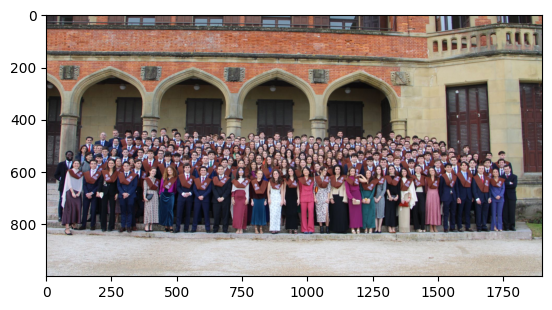

In [55]:
# Let's load the image to which we want to apply color segmentation and plot it
import PIL
img = PIL.Image.open(path_google_drive)
plt.imshow(img)